In [14]:
from queue import PriorityQueue, LifoQueue
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import copy

In [15]:
class Cell: 
    
    OPEN = 0
    BLOCKED = -1
    ON_FIRE = 2
    NO_PREV = (-1, -1)
    
    def __init__(self, coords, prev = None, f = 0, g = 0, h = -1):
        self.coords = coords
        self.prev = prev
        self.f = f
        self.g = g
        self.h = h
        
    def __lt__(self, other):   
        if self.f == other.f:
            if self.h == other.h:
                if self.g == other.g:
                    return self.coords > other.coords
                return self.g < other.g
            return 
        return self.f < other.f
    
    def __eq__(self, other):
        return self.coords == other.coords
    
    def __repr__(self):
        return str(self.coords) + " :: parent=" + ("NONE" if self.prev is None else str(self.prev.coords))

class Maze:
    def __init__(self, dim, p, q = 0):
        self.board =  np.zeros([dim, dim], dtype=int)
        self.dim = dim
        self.currentfire = []
        self.q = q
        self.p = p
        self.board_prob = np.zeros(shape=(dim**2,dim**2))
        self.fires = np.array([])
        obstaclesList = []
        for i in range(0, dim): #range() generates a list from 0 to dim-1 which can take up a lot of memory
            for j in range(0, dim):             
                if(rnd.random() < p):
                    self.board[i, j] = Cell.BLOCKED
                    obstaclesList.append((i, j))
        self.obstacles = np.array(obstaclesList)
        self.board[0, 0] = Cell.OPEN
        self.board[dim - 1, dim - 1] = Cell.OPEN

    def isSolvable(self):
        return pathExists(self)
    
    def startFire(self):
        i = rnd.randint(0,self.dim-1)
        j = rnd.randint(0,self.dim-1)
        while(self.board[i, j] == -1 or (i == 0 and j == 0) or (i == self.dim - 1 and j == self.dim - 1)):
            i = rnd.randint(0, self.dim - 1)
            j = rnd.randint(0, self.dim - 1)
        self.board[i,j] = Cell.ON_FIRE
        self.currentfire.append([i, j, None])
        self.fires = np.append(self.fires, [tupleToIndex(i, j, self.dim)])
        
    def resetFire(self):
        if (len(self.currentfire) == 1):
            fireRow, fireCol, ignored = self.currentfire[0]
            self.board[fireRow, fireCol] = Cell.OPEN
            self.currentfire = []  
        
    def isFireReachableToAgent(self):
        if (len(self.currentfire) == 1): 
            fireRow, fireCol, ignored = self.currentfire[0]
            return pathExists(self,fromCoords=(0, 0), toCoords=(fireRow, fireCol))
    
    def iterateFire(self):
        visited = [] #neighbors already visited in current iteration
        nowonfire = [] #need to append all new fires at the end 
        for f in self.currentfire:
            if(f[2] != 0): #check to see if all neighbors are already on fire. 
                neighbors = findNeighboringFlammableCoords(f[0:2],self) #calculate valid neighbors of f, the cell that is currently on fire
                ofnbor = 0 #counter to find out how many neighbors are on fire
                for n in neighbors: #loop through the neighbors of f
                    nr,nc = n 
                    if (self.board[nr,nc] == Cell.ON_FIRE): 
                        ofnbor = ofnbor + 1 
                    else:
                        if(n[0:2] not in visited): #only roll once for each cell not on fire
                            if(self.board[nr,nc] != Cell.BLOCKED):
                                surroundings = findNeighboringFlammableCoords(n[0:2],self) #see what the neighbors are for the neighbor of f
                                k = 0 #k will be guaranteed to be at least 1
                                for nn in surroundings:
                                    nnr,nnc = nn
                                    if(self.board[nnr,nnc] == Cell.ON_FIRE):
                                        k = k + 1 #counter
                                if(rnd.random() <= (1-((1-self.q)**k))): #roll
                                    self.board[nr,nc] = Cell.ON_FIRE 
                                    nowonfire.append([nr,nc,None])
                                    ofnbor = ofnbor + 1
                                else:
                                    visited.append([nr,nc])
                if(ofnbor == len(neighbors)):
                        f[2] = 0
        if(nowonfire):
            for x in nowonfire:
                self.currentfire.append(x)
                self.fires = np.append(self.fires, tupleToIndex(x[0], x[1], self.dim))
            return True
        return False

def pathExists(maze, fromCoords = (0,0), toCoords = None):
    if toCoords is None:
        toCoords = (maze.dim - 1, maze.dim - 1)
    toRow, toCol = toCoords
    visited = set()
    fringe = LifoQueue()
    fringe.put(fromCoords)
    while not fringe.empty():
        currentCoords = fringe.get()
        currentRow, currentCol = currentCoords
        if (currentRow == toRow and currentCol == toCol):
            return True
        else:
            neighbors = findNeighboringOpenCoords(currentCoords, maze)
            for neighbor in neighbors:
                if neighbor in visited:
                    continue
                fringe.put(neighbor)
            visited.add(currentCoords)
    return False

def findNeighboringOpenCoords(coords, maze):
    cellRow, cellCol = coords
    potentialNeighbors = [(cellRow + 1, cellCol), (cellRow - 1, cellCol), (cellRow, cellCol - 1), (cellRow, cellCol + 1)]
    neighbors = []
    for potentialNeighbor in potentialNeighbors:
        row, col = potentialNeighbor
        if (row >= maze.dim or row < 0 or col >= maze.dim or col < 0 or maze.board[row,col] != Cell.OPEN):
            continue
        neighbors.append(potentialNeighbor)
    return neighbors

def findNeighboringFlammableCoords(coords,maze): 
    cellRow, cellCol = coords
    potentialNeighbors = [(cellRow + 1, cellCol), (cellRow - 1, cellCol), (cellRow, cellCol - 1), (cellRow, cellCol + 1)]
    neighbors = []
    for potentialNeighbor in potentialNeighbors:
        row, col = potentialNeighbor
        if (row >= maze.dim or row < 0 or col >= maze.dim or col < 0 or maze.board[row,col] == Cell.BLOCKED):
            continue
        neighbors.append(potentialNeighbor)
    return neighbors

def uniformCost(cell, maze, visited):
    return 0

def adjacentFireHeuristic(cell, maze,visited):
    cellRow = cell.coords[0]
    cellCol = cell.coords[1]
    potentialNeighbors = [(cellRow + 1, cellCol), (cellRow - 1, cellCol), (cellRow, cellCol - 1), (cellRow, cellCol + 1)] #identify all potential neighbors to current cell
    weight = 1
    for potentialNeighbor in potentialNeighbors:
        row, col = potentialNeighbor
        if (row >= maze.dim or row < 0 or col >= maze.dim or col < 0 or maze.board[row,col] != 2): #if the neighbor is out-of-bounds or not on fire, ignore it
            continue
        weight += 1 #add 1 to weight for each neighbor of the current cell that is on fire
    #print(weight)
    return weight

def shortestPathSearch(maze, startCoords = (0, 0), goalCoords = None, heuristicFunction = uniformCost, findNeighborsFunction = findNeighboringOpenCoords):
    if goalCoords is None:
        goalCoords = (maze.dim - 1, maze.dim - 1)
    startCell = Cell(startCoords)
    visited = set()
    fringe = PriorityQueue()
    fringe.put(startCell)
    heuristicVisited = {}
    expandedCells = 0
    while not fringe.empty():
        currentCell = fringe.get()
        if (currentCell.coords) in visited:
            continue
        if (currentCell.coords == goalCoords):
            shortestPath = []
            while (currentCell is not None):
                shortestPath.append(currentCell.coords)
                currentCell = currentCell.prev
            shortestPath.reverse()
            return (shortestPath, expandedCells)
        else:
            neighborsCoordsList = findNeighborsFunction(coords = currentCell.coords, maze = maze)
            for neighborCoords in neighborsCoordsList:
                if neighborCoords in visited:
                    continue
                neighbor = Cell(neighborCoords, prev = currentCell)
                neighbor.g = currentCell.g + 1
                neighbor.h = heuristicFunction(cell = neighbor, maze = maze, visited = heuristicVisited)
                neighbor.f = neighbor.g + neighbor.h
                fringe.put(neighbor)
            visited.add(currentCell.coords)
            expandedCells += 1
    return None

In [16]:
def run_firstStrat(maze):
    m = maze
    path = None
    result = shortestPathSearch(m)
    if result != None:
        path = result[0]
    #print(path)
    if path == None:
        return False
    # using the initial path generated, iterate through the path, checking if one of the cells along the path catches fire
    for p in path:
        checki = p[0] 
        checkj = p[1]
        #print(checki)
        if maze.board[(checki,checkj)] == 2: # if the current cell is fire, return False
            return False
        elif checki == maze.dim - 1 and checkj == maze.dim - 1: # if goal, return True
            return True
        else:
            m.iterateFire()

In [17]:
def run_secondStrat(maze):
    """
    Algorithm:
    1. Identify shortest path to goal
        1.1. If found, move agent according to path
        1.2. Else, keep the agent in place
    2. Check if the agent reached the goal
        2.1. If true, terminate and return success
        2.2. Else, continue
    3. Advance the fire and check if the agent is burned
        3.1. If burned, terminate and return failure
        3.2. Else, continue at step 1
    """
    m = maze
    #m.startFire()
    agent = (0,0)
    shortestPath = None
    while True: #Loop exit conditions: Agent reaches goal or agent gets burned
        result = shortestPathSearch(m, agent) #recalculate the shortest path from the agent to the goal at agent's turn
        if result != None:
            shortestPath = result[0]
        else:
            return False
        if shortestPath != None: #if a shortest path was found, move the agent in that direction
            agent = shortestPath[1]
        if agent == (m.dim-1, m.dim-1): #returns true if the agent reaches the goal, otherwise continue
            return True
        m.iterateFire() #advances the fire immediately after the agent's turn
        if m.board[agent] == 2: #returns false if the fire reaches the agent, otherwise continue
            return False

In [18]:
def run_thirdStrat(maze):
    """
    Algorithm:
    1. Identify shortest path to goal
        1.1. If found, move agent according to path
        1.2. Else, keep the agent in place
    2. Check if the agent reached the goal
        2.1. If true, terminate and return success
        2.2. Else, continue
    3. Advance the fire and check if the agent is burned
        3.1. If burned, terminate and return failure
        3.2. Else, continue at step 1
    """
    m = maze
    #m.startFire()
    agent = (0,0)
    shortestPath = None
    while True: #Loop exit conditions: Agent reaches goal or agent gets burned
        result = shortestPathSearch(m, agent, heuristicFunction=adjacentFireHeuristic) #recalculate the shortest weighted path from the agent to the goal using the adjacentFireHeuristic
        if result != None:
            shortestPath = result[0]
        else:
            return False
        if shortestPath != None: #if a shortest path exists, advance the agent one step along the path
            agent = shortestPath[1]
        if agent == (m.dim-1, m.dim-1): #if the agent reached the goal, return True
            return True
        m.iterateFire() #advances the fire immediately after the agent's turn
        if m.board[agent] == 2: #if the agent's current cell is now on fire, return False
            return False

In [36]:
def run_strat4(maze):
    num_sims = 30
    for x in range(num_sims): 
        copiedMaze = copy.deepcopy(maze) #deepcopies the inputted maze to reset fire upon every simulation
        oldFires = np.array([])
        for y in range(maze.dim**2): #the upper bound on the total number of timesteps is dim squared
            oldFires = copy.deepcopy(copiedMaze.fires) #deepcopies the current mazes's fires before advancing the fire
            if(copiedMaze.iterateFire()):
                newFires = np.setdiff1d(copiedMaze.fires, oldFires) #stores the newly created fires
                for f in newFires:
                    maze.board_prob[int(f)][y] += 1.0 #increments the specific cell, timestep count
    for index in range(maze.dim**2):
        maze.board_prob[index] = np.divide(maze.board_prob[index], num_sims) #divides each ignitition count by the number of simulations
    
    agent = (0,0)
    while True:
        result = shortestPathSearch(maze, startCoords = agent, heuristicFunction = simulationHeuristic) #runs the shortest path algorithm using the probability heuristic
        if result is not None:
            shortestPath = result[0] #deconstructs the result if it exists
        else:
            return False
        if shortestPath != None:
            agent = shortestPath[1] #moves the agent if there is a shortest path
        if agent == (maze.dim-1, maze.dim-1):
            return True #returns true if the agent has reached the goal
        maze.iterateFire()
        if maze.board[agent] == 2:
            return False #returns false if the agent gets burned by the fire
def simulationHeuristic(cell, maze, visited):
    #The weight is equal to the probability that a cell catches fire at a specific timestep
    #cell.g stores the smallest possible timestep that that specific cell can be reached
    weight = maze.board_prob[tupleToIndex(cell.coords[0], cell.coords[1], maze.dim)][int(cell.g)] 
    return weight
def tupleToIndex(r, c, dim):
    return dim * r + c #converts cell tuples to unique integers
def indexToTuple(i, dim):
    return (int(i / dim), i % dim) #converts the unique integers back into their respective tuples

In [39]:
m = Maze(10, 0.3, 0.3)
while(m.isSolvable() == False):
    m = Maze(10, 0.3, 0.3)
m.startFire()
print(run_strat4(m))

False


In [88]:
def testStrategy(strategy=run_thirdStrat, dim=30, p=0.3):
#     dim = 10
#     p = 0.3
    q = 0.1
    q_values = []
    avgSuccesses = []
    
    while q < 1: # run strategy for each test value of q (flammability rate)
        run_count = 0
        success_count = 0
        fail_count = 0
        
        testMaze = Maze(dim, p, q)
        while(testMaze.isSolvable() == False):
            testMaze = Maze(dim, p, q)
        maze = copy.deepcopy(testMaze)
        
        while run_count < 100: # generate 30 valid(solvable) mazes
            maze.startFire()
            result = strategy(maze)
            if result == True: # if agent survives, increment number of successes for this given q
                success_count +=1
            elif result == None:
                continue
            else:
                fail_count +=1
            run_count += 1
            maze = copy.deepcopy(testMaze)
        
        successRate = success_count / (success_count + fail_count) # calculate success rate given all of the generated mazes for given q
        q_values.append(q)
        avgSuccesses.append(successRate)
        q += 0.05
    
    q_values_array = np.asarray(q_values)
    avgSuccessRate = np.asarray(avgSuccesses)
    
    plt.figure()
    plt.plot(q_values_array, avgSuccessRate, 'o')
    plt.xlabel("flammability rate")
    plt.ylabel("average success rate")
    plt.title(strategy.__name__)
    plt.show()

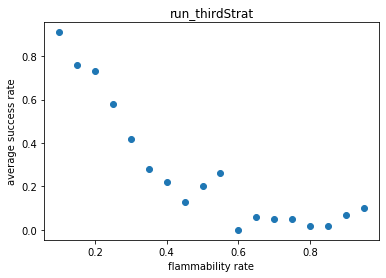

In [89]:
testStrategy()